In [1]:
# Cell 1 - import the things you need
import logging
import sys
import time

import numpy as np
import pandas as pd

from hamilton import base, driver

logging.basicConfig(stream=sys.stdout, level=logging.INFO)

In [2]:
# Cell 2 - import modules to create part of the DAG from
import my_functions
import importlib
importlib.reload(my_functions) # rerun this cell if you update `my_functions.py`

<module 'my_functions' from '/Users/stefankrawczyk/dagworks/hamilton/examples/dask/community_demo/my_functions.py'>

In [3]:
# Cell 3 - Instantiate the Hamilton driver and pass it the right things in.

initial_config = {}
# we need to tell hamilton where to load function definitions from
dr = driver.Driver(initial_config, my_functions)  # can pass in multiple modules
# we need to specify what we want in the final dataframe.
output_columns = [
    "spend",
    "signups",
    "avg_3wk_spend",
    "spend_per_signup",
    "spend_zero_mean_unit_variance",
]

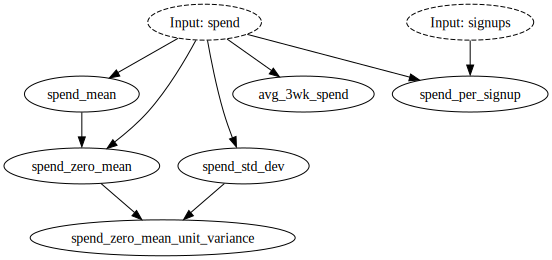

In [4]:
# Cell 4 - we can visualize the entire DAG
# To visualize do `pip install "sf-hamilton[visualization]"` if you want these to work

# visualize all possible nodes
dr.display_all_functions(None)  # we pass None to not save the image to file.

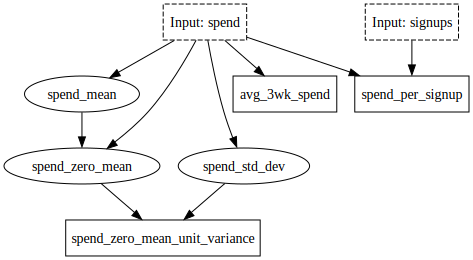

In [5]:
# Cell 5 - we can visualize just the execution path
dr.visualize_execution(output_columns, None, {}, 
                       inputs={"signups": pd.Series([1, 10, 50, 100, 200, 400]),
                               "spend": pd.Series([10, 10, 20, 40, 40, 50])})   # we pass None to not save the image to file.

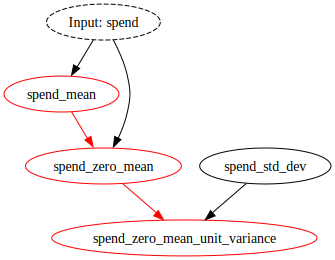

In [6]:
# Cell 6 - we can visualize the path of execution between two functions
dr.visualize_path_between("spend_mean", "spend_zero_mean_unit_variance", None, # we pass None to not save the image to file.
                          strict_path_visualization=False)

In [7]:
%%time
# Cell 7 - we can execute the DAG
# let's create the dataframe!
df = dr.execute(output_columns, 
                inputs={"signups": pd.Series([1, 10, 50, 100, 200, 400]),
                        "spend": pd.Series([10, 10, 20, 40, 40, 50])})
# it should take 9 seconds to compute due to the three 3 second sleeps.
df 

CPU times: user 6.57 ms, sys: 3.7 ms, total: 10.3 ms
Wall time: 9.01 s


,spend,signups,avg_3wk_spend,spend_per_signup,spend_zero_mean_unit_variance
0,10,1,NaN,10.000,-1.064405
1,10,10,NaN,1.000,-1.064405
2,20,50,13.333333,0.400,-0.483821
3,40,100,23.333333,0.400,0.677349
4,40,200,33.333333,0.200,0.677349
5,50,400,43.333333,0.125,1.257934


# Dask bit - let's "distribute" each function.

In [8]:
# Cell 8 - Set up dask locally
# Dask graph adapter -- let's distribute the functions!
import logging
from hamilton import base, driver
from hamilton.plugins import h_dask
from dask.distributed import Client, LocalCluster
logger = logging.getLogger("notebook_logger")
# Setup a local cluster.
# By default this sets up 1 worker per core
cluster = LocalCluster()
client = Client(cluster)
logger.info(client.cluster)

INFO:distributed.http.proxy:To route to workers diagnostics web server please install jupyter-server-proxy: python -m pip install jupyter-server-proxy
INFO:distributed.scheduler:State start
INFO:distributed.diskutils:Found stale lock file and directory '/var/folders/gv/q39lb_1s26x7gbyyypqc3dkm0000gn/T/dask-scratch-space/scheduler-9a4vlpji', purging
INFO:distributed.diskutils:Found stale lock file and directory '/var/folders/gv/q39lb_1s26x7gbyyypqc3dkm0000gn/T/dask-scratch-space/scheduler-j9vpovmg', purging
INFO:distributed.scheduler:  Scheduler at:     tcp://127.0.0.1:53454
INFO:distributed.scheduler:  dashboard at:  http://127.0.0.1:8787/status
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:53457'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:53458'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:53459'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:53460'
INFO:distributed.scheduler:Register worker <WorkerState 'tcp:/

In [9]:
# Cell 9 - Instantiate the graph adapter for Hamilton and the new Driver
dga = h_dask.DaskGraphAdapter(client, base.PandasDataFrameResult())
# create the new driver, which will now create dask delayed calls for each function.
dr2 = driver.Driver({}, my_functions, adapter=dga)

In [10]:
%%time
# Cell 10 - run the DAG again, but this time with dask
df2 = dr2.execute(
    output_columns, 
    inputs={"signups": pd.Series([1, 10, 50, 100, 200, 400]),
            "spend": pd.Series([10, 10, 20, 40, 40, 50])})
df2

CPU times: user 266 ms, sys: 56.8 ms, total: 323 ms
Wall time: 3.05 s


,spend,signups,avg_3wk_spend,spend_per_signup,spend_zero_mean_unit_variance
0,10,1,NaN,10.000,-1.064405
1,10,10,NaN,1.000,-1.064405
2,20,50,13.333333,0.400,-0.483821
3,40,100,23.333333,0.400,0.677349
4,40,200,33.333333,0.200,0.677349
5,50,400,43.333333,0.125,1.257934


In [11]:
# Cell 10 - clean things up
client.shutdown()
cluster.close()

INFO:distributed.nanny:Closing Nanny at 'tcp://127.0.0.1:53457'. Reason: nanny-close
INFO:distributed.nanny:Nanny asking worker to close. Reason: nanny-close
INFO:distributed.nanny:Closing Nanny at 'tcp://127.0.0.1:53458'. Reason: nanny-close
INFO:distributed.nanny:Nanny asking worker to close. Reason: nanny-close
INFO:distributed.nanny:Closing Nanny at 'tcp://127.0.0.1:53459'. Reason: nanny-close
INFO:distributed.nanny:Nanny asking worker to close. Reason: nanny-close
INFO:distributed.nanny:Closing Nanny at 'tcp://127.0.0.1:53460'. Reason: nanny-close
INFO:distributed.nanny:Nanny asking worker to close. Reason: nanny-close
INFO:distributed.core:Received 'close-stream' from tcp://127.0.0.1:53473; closing.
INFO:distributed.core:Received 'close-stream' from tcp://127.0.0.1:53475; closing.
INFO:distributed.core:Received 'close-stream' from tcp://127.0.0.1:53477; closing.
INFO:distributed.scheduler:Remove worker <WorkerState 'tcp://127.0.0.1:53468', name: 0, status: closing, memory: 0, pro